# Exploring the NHDPlus Seamless CONUS gdb
## Making tools to access individual features quickly

In [1]:
import sys; sys.path.append('..')

In [8]:
import fiona
import fiona.crs
import shapely
from shapely.geometry import shape
from osgeo import ogr
import json
import os

### Set the gdb path and the layer name
gdb source: http://www.horizon-systems.com/NHDPlus/V2NationalData.php

download link: http://www.horizon-systems.com/NHDPlusData/NHDPlusV21/Data/NationalData/NHDPlusV21_NationalData_Seamless_Geodatabase_Lower48_07.7z

documentation: http://www.horizon-systems.com/NHDPlusData/NHDPlusV21/Data/NationalData/0Release_Notes_NationalData_Seamless_GeoDatabase.pdf

In [9]:
gdb = r'data\NHDPlusV21\NHDPlusV21_National_Seamless_Flattened_Lower48.gdb'
lyr = 'NHDFlowline_Network'

### Open the gdb, layer

In [10]:
src = fiona.open(gdb, layer=lyr)

### Make a dict that allow for easy/fast indexing of our layer of interest

In [11]:
comidDict = {src[f]['properties']['COMID']: f for f in src.keys()}

### Write it to a json

In [ ]:
with open('data/comidDict_NHDPlusV21.json', 'w') as fp:
    json.dump(comidDict, fp, indent=2)

# END

---

#### dev work below

In [12]:
comid = 4512772 # some small segment on the Potomac near DC
comids = [4512772, 229757]

In [13]:
# import importlib
# import fcast
# importlib.reload(fcast)
from fcast import StreamSegmentNHD

In [14]:
test = StreamSegmentNHD(comid, comidDict, src)

..\fcast\NHDPlusStreamSegment.py:53: UserWarning: Make sure your comidDict json NHDPlus version matches your gdb NHDPlus version
  warnings.warn("Make sure your comidDict json NHDPlus version matches your gdb NHDPlus version")


In [15]:
test = StreamSegmentNHD(comid, comidDict, src, warning=False)

In [16]:
test.crs_wkt

'GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]]'

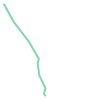

In [17]:
test.geometry